
This notebook provides an introductory tutorial for [**MuJoCo XLA (MJX)**](https://github.com/google-deepmind/mujoco/blob/main/mjx), a JAX-based implementation of MuJoCo useful for RL training workloads.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".










### Copyright notice

> <p><small><small>Copyright 2023 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Install MuJoCo, MJX, and Brax

In [9]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List
from tqdm import tqdm

# Graphics and plotting.
# print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [10]:
#@title Import MuJoCo, MJX, and Brax


from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, MjxEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx


# Introduction to MJX

MJX is an implementation of MuJoCo written in [JAX](https://jax.readthedocs.io/en/latest/index.html), enabling large batch training on GPU/TPU. In this notebook, we will demonstrate how to train RL policies with MJX.

Before we get into hefty RL workloads, let's get started with a simpler example! The entrypoint into MJX is through MuJoCo, so first we load a MuJoCo model:

In [3]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

# Make model, data, and renderer
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

Next we take the MuJoCo model and data, and place them on the GPU device using MJX.

In [4]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

Below, we print the `qpos` from MuJoCo and MJX. Notice that the `qpos` for the mjData is a numpy array living on the CPU, while the `qpos` for `mjx.Data` is a JAX Array living on the GPU device.

In [5]:
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[0.] <class 'numpy.ndarray'>
[0.] <class 'jaxlib.xla_extension.ArrayImpl'> {cuda(id=0)}


Let's run the simulation in MuJoCo and render the trajectory. This example is taken from the [MuJoCo tutorial](https://colab.sandbox.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb).

In [6]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

Now let's run the same exact simulation on the GPU device using MJX!

In the example below, we use `mjx.step` instead of `mujoco.mj_step`, and we also [`jax.jit`](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) the `mjx.step` so that it runs efficiently on the GPU. After each step, we convert the `mjx.Data` back to `mjData` so that we can use the MuJoCo renderer.


In [8]:

jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

Running single threaded physics simulation on the GPU is not very [efficient](https://mujoco.readthedocs.io/en/stable/mjx.html#mjx-the-sharp-bits). The advantage with MJX is that we can run environments in parallel on a hardware accelerated device. Let's try it out!

In the example below, we create 4096 copies of the `mjx.Data` and we run the `mjx.step` over the batched data. Since MJX is implemented in JAX, we take advantage of [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) to run the `mjx.step` in parallel over all `mjx.Data`.

In [9]:
# rng = jax.random.PRNGKey(0)
# rng = jax.random.split(rng, 4096)
# batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (1,))))(rng)

# jit_step = jax.vmap(mjx.step, in_axes=(None, 0))
# batch = jit_step(mjx_model, batch)

# print(batch.qpos)

We can copy the batched `mjx.Data` back to MuJoCo like we did before:

# Training a Policy with MJX

Running large batch physics simulation is useful for training RL policies. Here we demonstrate training RL policies with MJX using the RL library from [Brax](https://github.com/google/brax).

Below, we implement the classic Humanoid environment using MJX and Brax. We inherit from the `MjxEnv` implementation in Brax so that we can step the physics with MJX while training with Brax RL implementations.


In [7]:
#@title Humanoid Env

class Humanoid(MjxEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/benchmark/model/humanoid'
    )
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'humanoid.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)

    super().__init__(model=mj_model, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data.data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.data.subtree_com[1]
    com_after = data.data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data.data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('humanoid', Humanoid)

## Insert our custom Rodent Model

In [11]:
import yaml
from typing import List, Dict, Text

def load_params(param_path: Text) -> Dict:
    with open(param_path, "rb") as file:
        params = yaml.safe_load(file)
    return params

params = load_params("params/params.yaml")
model = mujoco.MjModel.from_xml_path(params["XML_PATH"])

#@title Rodent Env

class Rodent(MjxEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    params = load_params("params/params.yaml")
    mj_model = mujoco.MjModel.from_xml_path(params["XML_PATH"])
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)

    super().__init__(model=mj_model, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data.data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.data.subtree_com[1]
    com_after = data.data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data.data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('rodent', Rodent)

## Visualize a Rollout

Let's instantiate the environment and visualize a short rollout.

NOTE: Since episodes terminates early if the torso is below the healthy z-range, the only relevant contacts for this task are between the feet and the plane. We turn off other contacts.

In [8]:
# instantiate the environment
env_name = 'humanoid'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


In [13]:
from tqdm import tqdm
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]
frames = []

# grab a trajectory
for i in tqdm(range(200)):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

media.show_video(env.render(rollout, camera='side'), fps=1.0 / env.dt)

100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


In [26]:
# center of mass of each subtree
rollout[4].data.subtree_com

Array([[ 0.003, -0.01 ,  0.061],
       [ 0.003, -0.01 ,  0.061],
       [-0.027, -0.01 ,  0.063],
       [-0.027, -0.01 ,  0.063],
       [-0.028, -0.01 ,  0.063],
       [-0.028, -0.01 ,  0.063],
       [-0.028, -0.01 ,  0.062],
       [-0.029, -0.01 ,  0.062],
       [-0.029, -0.01 ,  0.062],
       [-0.026,  0.017,  0.047],
       [-0.031,  0.023,  0.03 ],
       [-0.039,  0.024,  0.014],
       [-0.025,  0.03 ,  0.005],
       [-0.025, -0.036,  0.046],
       [-0.029, -0.042,  0.029],
       [-0.037, -0.042,  0.013],
       [-0.023, -0.047,  0.004],
       [-0.058, -0.011,  0.056],
       [-0.065, -0.011,  0.05 ],
       [-0.07 , -0.012,  0.045],
       [-0.08 , -0.012,  0.038],
       [-0.09 , -0.013,  0.03 ],
       [-0.096, -0.013,  0.026],
       [-0.103, -0.013,  0.023],
       [-0.108, -0.014,  0.02 ],
       [-0.112, -0.014,  0.018],
       [-0.118, -0.014,  0.016],
       [-0.13 , -0.015,  0.014],
       [-0.135, -0.015,  0.013],
       [-0.142, -0.016,  0.012],
       [-0

## Train Humanoid Policy

Let's now train a policy with PPO to make the Humanoid run forwards. Training takes about 9-10 minutes on a Tesla A100 GPU.

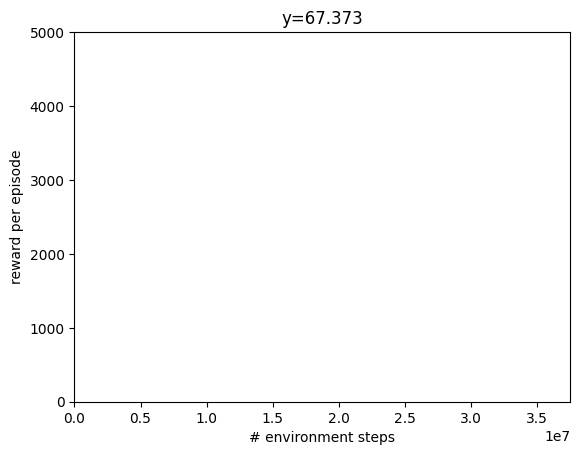

KeyboardInterrupt: 

In [11]:
train_fn = functools.partial(
    ppo.train, num_timesteps=30_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.96, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=128, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 5000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

<!-- ## Save and Load Policy -->

We can save and load the policy using the brax model API.

In [12]:
#@title Save Model
model_path = '/tmp/mjx_brax_policy'
model.save_params(model_path, params)

NameError: name 'params' is not defined

In [ ]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

Finally we can visualize the policy.

In [ ]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 1

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)

# MJX Policy in MuJoCo

We can also perform the physics step using the original MuJoCo python bindings to show that the policy trained in MJX works in MuJoCo.

In [ ]:
mj_model = eval_env._model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)

images = []
for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  obs = eval_env._get_obs(mjx.put_data(mj_model, mj_data), ctrl)
  ctrl, _ = jit_inference_fn(obs, act_rng)

  mj_data.ctrl = ctrl
  for _ in range(eval_env._n_frames):
    mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.

  if i % render_every == 0:
    renderer.update_scene(mj_data, camera='side')
    images.append(renderer.render())

media.show_video(images, fps=1.0 / eval_env.dt / render_every)

# Training a Policy with Domain Randomization

We might also want to include randomization over certain `mjModel` parameters while training a policy. In MJX, we can easily create a batch of environments with randomized values populated in `mjx.Model`. Below, we show a function that randomizes friction and actuator gain/bias.

In [ ]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
    friction = sys.geom_friction.at[:, 0].set(friction)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree_map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

If we wanted 10 environments with randomized friction and actuator params, we can call `domain_randomize`, which returns a batched `mjx.Model` along with a dictionary specifying the axes that are batched.

In [ ]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 10)
batched_sys, _ = domain_randomize(env.sys, rng)

print('Single env friction shape: ', env.sys.geom_friction.shape)
print('Batched env friction shape: ', batched_sys.geom_friction.shape)

print('Friction on geom 0: ', env.sys.geom_friction[0, 0])
print('Random frictions on geom 0: ', batched_sys.geom_friction[:, 0, 0])

## Quadruped Env

Let's define a quadruped environment that takes advantage of the domain randomization function. Here we use the [Barkour vb Quadruped](https://github.com/google-deepmind/mujoco_menagerie/tree/main/google_barkour_vb) from [MuJoCo Menagerie](https://github.com/google-deepmind/mujoco_menagerie). We implement an environment that trains a joystick policy with Brax.

In [ ]:
!git clone https://github.com/google-deepmind/mujoco_menagerie

In [ ]:
#@title Barkour vb Quadruped Env

def get_config():
  """Returns reward config for barkour quadruped environment."""

  def get_default_rewards_config():
    default_config = config_dict.ConfigDict(
        dict(
            # The coefficients for all reward terms used for training. All
            # physical quantities are in SI units, if no otherwise specified,
            # i.e. joint positions are in rad, positions are measured in meters,
            # torques in Nm, and time in seconds, and forces in Newtons.
            scales=config_dict.ConfigDict(
                dict(
                    # Tracking rewards are computed using exp(-delta^2/sigma)
                    # sigma can be a hyperparameters to tune.
                    # Track the base x-y velocity (no z-velocity tracking.)
                    tracking_lin_vel=1.5,
                    # Track the angular velocity along z-axis, i.e. yaw rate.
                    tracking_ang_vel=0.8,
                    # Below are regularization terms, we roughly divide the
                    # terms to base state regularizations, joint
                    # regularizations, and other behavior regularizations.
                    # Penalize the base velocity in z direction, L2 penalty.
                    lin_vel_z=-2.0,
                    # Penalize the base roll and pitch rate. L2 penalty.
                    ang_vel_xy=-0.05,
                    # Penalize non-zero roll and pitch angles. L2 penalty.
                    orientation=-5.0,
                    # L2 regularization of joint torques, |tau|^2.
                    torques=-0.0002,
                    # Penalize the change in the action and encourage smooth
                    # actions. L2 regularization |action - last_action|^2
                    action_rate=-0.01,
                    # Encourage long swing steps.  However, it does not
                    # encourage high clearances.
                    feet_air_time=0.2,
                    # Encourage no motion at zero command, L2 regularization
                    # |q - q_default|^2.
                    stand_still=-0.5,
                    # Early termination penalty.
                    termination=-1.0,
                    # Penalizing foot slipping on the ground.
                    foot_slip=-0.1,
                )
            ),
            # Tracking reward = exp(-error^2/sigma).
            tracking_sigma=0.25,
        )
    )
    return default_config

  default_config = config_dict.ConfigDict(
      dict(
          rewards=get_default_rewards_config(),
      )
  )

  return default_config


class BarkourEnv(MjxEnv):
  """Environment for training the barkour quadruped joystick policy in MJX."""

  def __init__(
      self,
      obs_noise: float = 0.05,
      action_scale: float = 0.3,
      kick_vel: float = 0.05,
      **kwargs,
  ):
    path = epath.Path('mujoco_menagerie/google_barkour_vb/scene_mjx.xml')
    self._dt = 0.02  # this environment is 50 fps
    self.brax_sys = mjcf.load(path).replace(dt=self._dt)
    model = self.brax_sys.get_model()
    model.opt.timestep = 0.004

    # override menagerie params for smoother policy
    model.dof_damping[6:] = 0.5239
    model.actuator_gainprm[:, 0] = 35.0
    model.actuator_biasprm[:, 1] = -35.0

    n_frames = kwargs.pop('n_frames', int(self._dt / model.opt.timestep))
    super().__init__(model=model, n_frames=n_frames)

    self.reward_config = get_config()
    # set custom from kwargs
    for k, v in kwargs.items():
      if k.endswith('_scale'):
        self.reward_config.rewards.scales[k[:-6]] = v

    self._torso_idx = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_BODY.value, 'torso'
    )
    self._action_scale = action_scale
    self._obs_noise = obs_noise
    self._kick_vel = kick_vel
    self._init_q = jp.array(model.keyframe('home').qpos)
    self._default_pose = model.keyframe('home').qpos[7:]
    self.lowers = jp.array([-0.7, -1.0, 0.05] * 4)
    self.uppers = jp.array([0.52, 2.1, 2.1] * 4)
    feet_site = [
        'foot_front_left',
        'foot_hind_left',
        'foot_front_right',
        'foot_hind_right',
    ]
    feet_site_id = [
        mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE.value, f)
        for f in feet_site
    ]
    assert not any(id_ == -1 for id_ in feet_site_id), 'Site not found.'
    self._feet_site_id = np.array(feet_site_id)
    lower_leg_body = [
        'lower_leg_front_left',
        'lower_leg_hind_left',
        'lower_leg_front_right',
        'lower_leg_hind_right',
    ]
    lower_leg_body_id = [
        mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY.value, l)
        for l in lower_leg_body
    ]
    assert not any(id_ == -1 for id_ in lower_leg_body_id), 'Body not found.'
    self._lower_leg_body_id = np.array(lower_leg_body_id)
    self._foot_radius = 0.0175
    self._nv = model.nv

  def sample_command(self, rng: jax.Array) -> jax.Array:
    lin_vel_x = [-0.6, 1.5]  # min max [m/s]
    lin_vel_y = [-0.8, 0.8]  # min max [m/s]
    ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

    _, key1, key2, key3 = jax.random.split(rng, 4)
    lin_vel_x = jax.random.uniform(
        key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
    )
    lin_vel_y = jax.random.uniform(
        key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
    )
    ang_vel_yaw = jax.random.uniform(
        key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
    )
    new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
    return new_cmd

  def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, key = jax.random.split(rng)

    pipeline_state = self.pipeline_init(self._init_q, jp.zeros(self._nv))

    state_info = {
        'rng': rng,
        'last_act': jp.zeros(12),
        'last_vel': jp.zeros(12),
        'command': self.sample_command(key),
        'last_contact': jp.zeros(4, dtype=bool),
        'feet_air_time': jp.zeros(4),
        'rewards': {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
        'kick': jp.array([0.0, 0.0]),
        'step': 0,
    }

    obs_history = jp.zeros(15 * 31)  # store 15 steps of history
    obs = self._get_obs(pipeline_state, state_info, obs_history)
    reward, done = jp.zeros(2)
    metrics = {'total_dist': 0.0}
    for k in state_info['rewards']:
      metrics[k] = state_info['rewards'][k]
    state = State(pipeline_state, obs, reward, done, metrics, state_info)  # pytype: disable=wrong-arg-types
    return state

  def step(self, state: State, action: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, cmd_rng, kick_noise_2 = jax.random.split(state.info['rng'], 3)

    # kick
    push_interval = 10
    kick_theta = jax.random.uniform(kick_noise_2, maxval=2 * jp.pi)
    kick = jp.array([jp.cos(kick_theta), jp.sin(kick_theta)])
    kick *= jp.mod(state.info['step'], push_interval) == 0
    qvel = state.pipeline_state.data.qvel  # pytype: disable=attribute-error
    qvel = qvel.at[:2].set(kick * self._kick_vel + qvel[:2])
    state = state.tree_replace({'pipeline_state.data.qvel': qvel})

    # physics step
    motor_targets = self._default_pose + action * self._action_scale
    motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
    pipeline_state = self.pipeline_step(state.pipeline_state, motor_targets)
    x, xd = pipeline_state.x, pipeline_state.xd

    # observation data
    obs = self._get_obs(pipeline_state, state.info, state.obs)
    joint_angles = pipeline_state.q[7:]
    joint_vel = pipeline_state.qd[6:]

    # foot contact data based on z-position
    foot_pos = pipeline_state.data.site_xpos[self._feet_site_id]  # pytype: disable=attribute-error
    foot_contact_z = foot_pos[:, 2] - self._foot_radius
    contact = foot_contact_z < 1e-3  # a mm or less off the floor
    contact_filt_mm = contact | state.info['last_contact']
    contact_filt_cm = (foot_contact_z < 3e-2) | state.info['last_contact']
    first_contact = (state.info['feet_air_time'] > 0) * contact_filt_mm
    state.info['feet_air_time'] += self.dt

    # done if joint limits are reached or robot is falling
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
    done |= jp.any(joint_angles < self.lowers)
    done |= jp.any(joint_angles > self.uppers)
    done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

    # reward
    rewards = {
        'tracking_lin_vel': (
            self._reward_tracking_lin_vel(state.info['command'], x, xd)
        ),
        'tracking_ang_vel': (
            self._reward_tracking_ang_vel(state.info['command'], x, xd)
        ),
        'lin_vel_z': self._reward_lin_vel_z(xd),
        'ang_vel_xy': self._reward_ang_vel_xy(xd),
        'orientation': self._reward_orientation(x),
        'torques': self._reward_torques(pipeline_state.data.qfrc_actuator),  # pytype: disable=attribute-error
        'action_rate': self._reward_action_rate(action, state.info['last_act']),
        'stand_still': self._reward_stand_still(
            state.info['command'], joint_angles,
        ),
        'feet_air_time': self._reward_feet_air_time(
            state.info['feet_air_time'],
            first_contact,
            state.info['command'],
        ),
        'foot_slip': self._reward_foot_slip(pipeline_state, contact_filt_cm),
        'termination': self._reward_termination(done, state.info['step']),
    }
    rewards = {
        k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
    }
    reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

    # state management
    state.info['kick'] = kick
    state.info['last_act'] = action
    state.info['last_vel'] = joint_vel
    state.info['feet_air_time'] *= ~contact_filt_mm
    state.info['last_contact'] = contact
    state.info['rewards'] = rewards
    state.info['step'] += 1
    state.info['rng'] = rng

    # sample new command if more than 500 timesteps achieved
    state.info['command'] = jp.where(
        state.info['step'] > 500,
        self.sample_command(cmd_rng),
        state.info['command'],
    )
    # reset the step counter when done
    state.info['step'] = jp.where(
        done | (state.info['step'] > 500), 0, state.info['step']
    )

    # log total displacement as a proxy metric
    state.metrics['total_dist'] = math.normalize(x.pos[self._torso_idx - 1])[1]
    state.metrics.update(state.info['rewards'])

    done = jp.float32(done)
    state = state.replace(
        pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
    )
    return state

  def _get_obs(
      self,
      pipeline_state: base.State,
      state_info: dict[str, Any],
      obs_history: jax.Array,
  ) -> jax.Array:
    inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
    local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

    obs = jp.concatenate([
        jp.array([local_rpyrate[2]]) * 0.25,                 # yaw rate
        math.rotate(jp.array([0, 0, -1]), inv_torso_rot),    # projected gravity
        state_info['command'] * jp.array([2.0, 2.0, 0.25]),  # command
        pipeline_state.q[7:] - self._default_pose,           # motor angles
        state_info['last_act'],                              # last action
    ])

    # clip, noise
    obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
        state_info['rng'], obs.shape, minval=-1, maxval=1
    )
    # stack observations through time
    obs = jp.roll(obs_history, obs.size).at[:obs.size].set(obs)

    return obs

  # ------------ reward functions----------------
  def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
    # Penalize z axis base linear velocity
    return jp.square(xd.vel[0, 2])

  def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
    # Penalize xy axes base angular velocity
    return jp.sum(jp.square(xd.ang[0, :2]))

  def _reward_orientation(self, x: Transform) -> jax.Array:
    # Penalize non flat base orientation
    up = jp.array([0.0, 0.0, 1.0])
    rot_up = math.rotate(up, x.rot[0])
    return jp.sum(jp.square(rot_up[:2]))

  def _reward_torques(self, torques: jax.Array) -> jax.Array:
    # Penalize torques
    return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

  def _reward_action_rate(
      self, act: jax.Array, last_act: jax.Array
  ) -> jax.Array:
    # Penalize changes in actions
    return jp.sum(jp.square(act - last_act))

  def _reward_tracking_lin_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of linear velocity commands (xy axes)
    local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    lin_vel_reward = jp.exp(
        -lin_vel_error / self.reward_config.rewards.tracking_sigma
    )
    return lin_vel_reward

  def _reward_tracking_ang_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of angular velocity commands (yaw)
    base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
    ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
    return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

  def _reward_feet_air_time(
      self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
  ) -> jax.Array:
    # Reward air time.
    rew_air_time = jp.sum((air_time - 0.1) * first_contact)
    rew_air_time *= (
        math.normalize(commands[:2])[1] > 0.05
    )  # no reward for zero command
    return rew_air_time

  def _reward_stand_still(
      self,
      commands: jax.Array,
      joint_angles: jax.Array,
  ) -> jax.Array:
    # Penalize motion at zero commands
    return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
        math.normalize(commands[:2])[1] < 0.1
    )

  def _reward_foot_slip(
      self, pipeline_state: base.State, contact_filt: jax.Array
  ) -> jax.Array:
    # get velocities at feet which are offset from lower legs
    # pytype: disable=attribute-error
    pos = pipeline_state.data.site_xpos[self._feet_site_id]  # feet position
    feet_offset = pos - pipeline_state.data.xpos[self._lower_leg_body_id]
    # pytype: enable=attribute-error
    offset = base.Transform.create(pos=feet_offset)
    foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
    foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

    # Penalize large feet velocity for feet that are in contact with the ground.
    return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))

  def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
    return done & (step < 500)

  def render(
      self, trajectory: List[base.State], camera: str | None = None
  ) -> Sequence[np.ndarray]:
    camera = camera or 'track'
    return super().render(trajectory, camera)

envs.register_environment('barkour', BarkourEnv)

In [ ]:
env_name = 'barkour'
env = envs.get_environment(env_name)

## Train Policy

To train a policy with domain randomization, we pass in the domain randomization function into the brax train function; brax will call the domain randomization function when rolling out episodes. Training the quadruped takes  8-9 minutes on a Tesla A100 GPU.

In [ ]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128, 128))
train_fn = functools.partial(
      ppo.train, num_timesteps=100_000_000, num_evals=10,
      reward_scaling=1, episode_length=1000, normalize_observations=True,
      action_repeat=1, unroll_length=20, num_minibatches=32,
      num_updates_per_batch=4, discounting=0.97, learning_rate=3.0e-4,
      entropy_cost=1e-2, num_envs=8192, batch_size=256,
      network_factory=make_networks_factory,
      randomization_fn=domain_randomize, seed=0)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 40, 0

# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)
make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
# Save and reload params.
model_path = '/tmp/mjx_brax_quadruped_policy'
model.save_params(model_path, params)
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

For the Barkour Quadruped, the joystick commands can be set through `x_vel`, `y_vel`, and `ang_vel`. `x_vel` and `y_vel` define the linear forward and sideways velocities with respect to the quadruped torso. `ang_vel` defines the angular velocity of the torso in the z direction.

In [ ]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
# @markdown Commands **only used for Barkour Env**:
x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
ang_vel = -0.5  #@param {type: "number"}

the_command = jp.array([x_vel, y_vel, ang_vel])

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
state.info['command'] = the_command
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

media.show_video(
    eval_env.render(rollout[::render_every], camera='track'),
    fps=1.0 / eval_env.dt / render_every)

We can also render the rollout using the Brax renderer.

In [ ]:
HTML(html.render(eval_env.brax_sys, rollout))